# DistilBERT for Phishing Email Detection

This notebook demonstrates how to build and evaluate a transformer-based model (DistilBERT) for phishing email classification with comprehensive evaluation metrics.

## Overview
- **Model**: DistilBERT for sequence classification
- **Dataset**: Phishing vs legitimate emails  
- **Optimization**: 4 lightweight training strategies (reduced length, mixed precision, pruning, TinyBERT)
- **Evaluation**: Comprehensive metrics (accuracy, precision, recall, F1-score, PR-AUC)


## 1. Import Required Libraries

In [3]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch and transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DistilBertTokenizer, 
    DistilBertForSequenceClassification,
    TrainingArguments, 
    Trainer,
    pipeline
)

# Sklearn for metrics and preprocessing
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, 
    confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import train_test_split

# Explainability libraries
try:
    import lime
    from lime.lime_text import LimeTextExplainer
    print("LIME imported successfully")
except ImportError:
    print("LIME not installed. Install with: pip install lime")
    
try:
    import shap
    print("SHAP imported successfully")
except ImportError:
    print("SHAP not installed. Install with: pip install shap")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

LIME not installed. Install with: pip install lime
SHAP not installed. Install with: pip install shap
All libraries imported successfully!
PyTorch version: 2.7.1+cu118
CUDA available: True
GPU: NVIDIA GeForce RTX 3090
Using device: cuda


In [5]:
print(torch.utils.collect_env.main())

PyTorch version: 2.7.1+cu118
Is debug build: False
CUDA used to build PyTorch: 11.8
ROCM used to build PyTorch: N/A

OS: Microsoft Windows 10 Pro (10.0.19045 64-bit)
GCC version: Could not collect
Clang version: Could not collect
CMake version: Could not collect
Libc version: N/A

Python version: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)] (64-bit runtime)
Python platform: Windows-10-10.0.19045-SP0
Is CUDA available: True
CUDA runtime version: 9.0.176
CUDA_MODULE_LOADING set to: LAZY
GPU models and configuration: GPU 0: NVIDIA GeForce RTX 3090
Nvidia driver version: 572.16
cuDNN version: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8\bin\cudnn_ops_train64_8.dll
HIP runtime version: N/A
MIOpen runtime version: N/A
Is XNNPACK available: True

CPU:
Name: 11th Gen Intel(R) Core(TM) i9-11900K @ 3.50GHz
Manufacturer: GenuineIntel
Family: 1
Architecture: 9
ProcessorType: 3
DeviceID: CPU0
CurrentClockSpeed: 3504
MaxClockSpeed: 3504

## 2. Load and Prepare Data

In [8]:
# Load the preprocessed data
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/test.csv")

print("Data loaded successfully from data/ directory")

SIMPLIFIED_TRAINING = False
if SIMPLIFIED_TRAINING:
    # keep only subset of samples for quicker experimentation
    train_df = train_df.sample(n=500, random_state=42)
    val_df = val_df.sample(n=100, random_state=42)
    test_df = test_df.sample(n=100, random_state=42)

# Data overview
print("\nDataset Overview:")
print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

print(f"\nDataset columns: {train_df.columns.tolist()}")

print(f"\nClass distribution in training set:")
print(train_df['label'].value_counts().rename({0: 'Legitimate', 1: 'Phishing'}))

# Text length analysis
train_df['text_length'] = train_df['text'].str.len()
print(f"\nText length statistics:")
print(f"Mean: {train_df['text_length'].mean():.0f} characters")
print(f"Median: {train_df['text_length'].median():.0f} characters")
print(f"Max: {train_df['text_length'].max()} characters")

# Show sample texts
print("\nSample legitimate email:")
legit_sample = train_df[train_df['label'] == 0]['text'].iloc[0]
print(f"'{legit_sample[:200]}...'")

print("\nSample phishing email:")
phish_sample = train_df[train_df['label'] == 1]['text'].iloc[0]
print(f"'{phish_sample[:200]}...'")

# Prepare data for model training - use 'text' column directly
X_train = train_df['text'].tolist()
y_train = train_df['label'].tolist()
X_val = val_df['text'].tolist()
y_val = val_df['label'].tolist()
X_test = test_df['text'].tolist()
y_test = test_df['label'].tolist()

print(f"\nData prepared for model training!")


Data loaded successfully from data/ directory

Dataset Overview:
Train samples: 35744
Validation samples: 41702
Test samples: 41702

Dataset columns: ['text', 'type', 'source', 'word_count', 'sentence_count', 'words_per_sentence', 'domain', 'label']

Class distribution in training set:
label
Phishing      20373
Legitimate    15371
Name: count, dtype: int64

Text length statistics:
Mean: 1383 characters
Median: 872 characters
Max: 65535 characters

Sample legitimate email:
'How are you. Wish you a great semester...'

Sample phishing email:
'
Attention: Sir/Madam,

I will like to know if you can handle the supply of your product to African Union Development Authority, through the ongoing Supply Tender.

The tender is open to all eligible ...'

Data prepared for model training!


## 3. Text Preprocessing for Transformers

## 3.5 Optimization Options for Faster Training

Choose ONE of the following lightweight approaches based on your needs:
- **Option A**: DistilBERT with reduced sequence length (faster)
- **Option B**: DistilBERT with mixed precision training (memory efficient)
- **Option C**: DistilBERT with model pruning (smallest model)
- **Option D**: TinyBERT (ultra-lightweight alternative)

This section demonstrates all options. Uncomment your preferred approach.


In [12]:
# ============================================================================
# OPTIMIZATION CONFIGURATION - preferred approach
# ============================================================================

# Set optimization preference here (1, 2, 3, or 4)
OPTIMIZATION_CHOICE = 4  # 1=Reduced Length, 2=Mixed Precision, 3=Pruning, 4=TinyBERT

print("MODEL OPTIMIZATION SETUP")
print("=" * 60)
print("\nAvailable optimization strategies:")
print("  1. Reduced Sequence Length (Fastest - minimal quality loss)")
print("  2. Mixed Precision Training (Fast - uses fp16)")
print("  3. Model Pruning (Medium - removes less important weights)")
print("  4. TinyBERT Model (Smallest - alternative ultra-light model)")
print(f"\n Selected: Option {OPTIMIZATION_CHOICE}")
print("=" * 60)

# ============================================================================
# OPTION 1: REDUCED SEQUENCE LENGTH (RECOMMENDED FOR FASTEST TRAINING)
# ============================================================================
if OPTIMIZATION_CHOICE == 1:
    print("\n Option 1: Reduced Sequence Length")
    print("-" * 60)
    
    # Use shorter max length - much faster without much quality loss
    MAX_LENGTH = 128  # Reduced from 512 (4x faster!)
    BATCH_SIZE = 32   # Can use larger batches with shorter sequences
    LEARNING_RATE = 3e-4  # Slightly higher LR for shorter sequences
    NUM_EPOCHS = 2    # Reduced epochs to save time
    
    print(f" Max sequence length: {MAX_LENGTH} (reduced from 512)")
    print(f" Batch size: {BATCH_SIZE}")
    print(f" Learning rate: {LEARNING_RATE}")
    print(f" Epochs: {NUM_EPOCHS}")
    print(f"\nExpected speedup: ~4-5x faster than full length")
    print(f" Quality impact: Minimal (emails are usually concise)")
    
    use_mixed_precision = False
    use_pruning = False
    tinybert = False

# ============================================================================
# OPTION 2: MIXED PRECISION TRAINING (fp16)
# ============================================================================
elif OPTIMIZATION_CHOICE == 2:
    print("\nOption 2: Mixed Precision Training (FP16)")
    print("-" * 60)
    
    MAX_LENGTH = 256   # Medium length
    BATCH_SIZE = 48    # Larger batch size possible with fp16
    LEARNING_RATE = 2e-4
    NUM_EPOCHS = 2
    
    print(f" Max sequence length: {MAX_LENGTH}")
    print(f" Batch size: {BATCH_SIZE}")
    print(f" Precision: Mixed (FP32 + FP16)")
    print(f" Epochs: {NUM_EPOCHS}")
    print(f"\nExpected speedup: ~2-3x faster + 50% less memory")
    print(f"Quality impact: Negligible")
    
    use_mixed_precision = True
    use_pruning = False
    tinybert = False
    
    # Install apex if using NVIDIA GPU for better mixed precision
    try:
        import torch
        if torch.cuda.is_available():
            print("\nFor best mixed precision performance on GPU:")
            print("   pip install apex")
    except:
        pass

# ============================================================================
# OPTION 3: MODEL PRUNING (Remove 30% of less important weights)
# ============================================================================
elif OPTIMIZATION_CHOICE == 3:
    print("\n Option 3: Model Pruning")
    print("-" * 60)
    
    MAX_LENGTH = 256
    BATCH_SIZE = 32
    LEARNING_RATE = 2e-4
    NUM_EPOCHS = 2
    PRUNING_AMOUNT = 0.3  # Remove 30% of weights
    
    print(f" Max sequence length: {MAX_LENGTH}")
    print(f" Batch size: {BATCH_SIZE}")
    print(f" Pruning amount: {PRUNING_AMOUNT*100:.0f}% of weights")
    print(f" Epochs: {NUM_EPOCHS}")
    print(f"\nExpected speedup: ~2-3x faster + 30% smaller model")
    print(f" Quality impact: Very small (1-2% accuracy drop)")
    
    use_mixed_precision = False
    use_pruning = True
    tinybert = False

# ============================================================================
# OPTION 4: TinyBERT (Ultra-lightweight alternative)
# ============================================================================
elif OPTIMIZATION_CHOICE == 4:
    print("\nOption 4: TinyBERT Model")
    print("-" * 60)
    
    model_name = "huawei-noah/TinyBERT_General_4L_312D"  # 4 layers, 312 dims
    MAX_LENGTH = 128
    BATCH_SIZE = 64   # TinyBERT is so light you can use huge batches
    LEARNING_RATE = 3e-4
    NUM_EPOCHS = 10
    
    print(f" Model: TinyBERT (4 layers, 312 hidden dims)")
    print(f" Base model: {model_name}")
    print(f" Max sequence length: {MAX_LENGTH}")
    print(f" Batch size: {BATCH_SIZE}")
    print(f" Epochs: {NUM_EPOCHS}")
    print(f"\n  Expected speedup: ~10x faster than DistilBERT")
    print(f"  Model size: Only 14MB vs DistilBERT 250MB")
    print(f" Quality impact: Acceptable (2-5% accuracy drop)")
    
    use_mixed_precision = False
    use_pruning = False
    tinybert = True

else:
    print("Invalid choice. Using Option 1 (Reduced Sequence Length)")
    MAX_LENGTH = 128
    BATCH_SIZE = 32
    LEARNING_RATE = 3e-4
    NUM_EPOCHS = 2
    use_mixed_precision = False
    use_pruning = False
    tinybert = False

print("\nConfiguration ready!")


MODEL OPTIMIZATION SETUP

Available optimization strategies:
  1. Reduced Sequence Length (Fastest - minimal quality loss)
  2. Mixed Precision Training (Fast - uses fp16)
  3. Model Pruning (Medium - removes less important weights)
  4. TinyBERT Model (Smallest - alternative ultra-light model)

 Selected: Option 4

Option 4: TinyBERT Model
------------------------------------------------------------
 Model: TinyBERT (4 layers, 312 hidden dims)
 Base model: huawei-noah/TinyBERT_General_4L_312D
 Max sequence length: 128
 Batch size: 64
 Epochs: 10

  Expected speedup: ~10x faster than DistilBERT
  Model size: Only 14MB vs DistilBERT 250MB
 Quality impact: Acceptable (2-5% accuracy drop)

Configuration ready!


In [14]:
# Initialize DistilBERT tokenizer
if not tinybert:
    model_name = "distilbert-base-uncased"
# model_name already set if using TinyBERT option
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

# MAX_LENGTH is now configured in optimization section above

class EmailDataset(Dataset):
    """Custom dataset class for email classification"""
    
    def __init__(self, texts, labels, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
print("Creating datasets...")
train_dataset = EmailDataset(X_train, y_train, tokenizer)
val_dataset = EmailDataset(X_val, y_val, tokenizer)
test_dataset = EmailDataset(X_test, y_test, tokenizer)

print(f" Train dataset: {len(train_dataset)} samples")
print(f" Validation dataset: {len(val_dataset)} samples") 
print(f" Test dataset: {len(test_dataset)} samples")

# Test tokenization on a sample
sample_text = X_train[0][:100]  # First 100 chars
sample_encoding = tokenizer(
    sample_text,
    truncation=True,
    padding='max_length', 
    max_length=min(50, MAX_LENGTH),  # Smaller for display
    return_tensors='pt'
)

print(f"\nTokenization example:")
print(f"Original text: '{sample_text}'")
print(f"Token IDs shape: {sample_encoding['input_ids'].shape}")
print(f"First 10 token IDs: {sample_encoding['input_ids'][0][:10].tolist()}")
print(f"Decoded tokens: {tokenizer.convert_ids_to_tokens(sample_encoding['input_ids'][0][:10])}")

# Analyze text lengths after tokenization
sample_lengths = []
for text in X_train[:1000]:  # Sample first 1000 for speed
    tokens = tokenizer(text, truncation=False, return_tensors='pt')
    sample_lengths.append(tokens['input_ids'].shape[1])

print(f"\nToken length statistics (sample):")
print(f"Mean tokens: {np.mean(sample_lengths):.1f}")
print(f"95th percentile: {np.percentile(sample_lengths, 95):.0f}")
print(f"Texts that would be truncated at {MAX_LENGTH}: {sum(1 for x in sample_lengths if x > MAX_LENGTH)} ({sum(1 for x in sample_lengths if x > MAX_LENGTH)/len(sample_lengths)*100:.1f}%)")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.


Creating datasets...
 Train dataset: 35744 samples
 Validation dataset: 41702 samples
 Test dataset: 41702 samples

Tokenization example:
Original text: '
Attention: Sir/Madam,

I will like to know if you can handle the supply of your product to African '
Token IDs shape: torch.Size([1, 50])
First 10 token IDs: [101, 3086, 1024, 2909, 1013, 21658, 1010, 1045, 2097, 2066]
Decoded tokens: ['[CLS]', 'attention', ':', 'sir', '/', 'madam', ',', 'i', 'will', 'like']

Token length statistics (sample):
Mean tokens: 358.6
95th percentile: 991
Texts that would be truncated at 128: 670 (67.0%)


In [16]:
# Load pre-trained model based on optimization choice
print("Loading model...")
print(f"Model name: {model_name}")

model = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification: phishing vs legitimate
    output_attentions=True,  # Enable attention weights for explainability
    output_hidden_states=False
)

# Apply model pruning if selected
if use_pruning:
    print("\nApplying model pruning...")
    from torch.nn.utils.prune import global_unstructured, remove
    
    # Get all model parameters
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))
    
    if parameters_to_prune:
        # Apply global pruning
        global_unstructured(
            parameters_to_prune,
            pruning_method=torch.nn.utils.prune.L1Unstructured,
            amount=PRUNING_AMOUNT
        )
        
        # Remove pruning reparameterization
        for module, name in parameters_to_prune:
            remove(module, name)
        
        print(f" Pruned {PRUNING_AMOUNT*100:.0f}% of weights")

# Move model to device
model.to(device)

print(f"\n Model loaded: {model.__class__.__name__}")
print(f" Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f" Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Calculate model size in MB
model_size = sum(p.numel() for p in model.parameters()) * 4 / (1024**2)
print(f" Model size: {model_size:.1f} MB")

# Try to use Trainer with optimizations
try:
    from transformers import TrainingArguments, Trainer
    
    # Define training arguments with optimizations
    training_args = TrainingArguments(
        output_dir="./models/distilbert-phishing",
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE * 2,
        warmup_steps=50,  # Reduced warmup
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=20,
        eval_strategy="steps",
        eval_steps=100,  # Evaluate less frequently
        save_strategy="steps",
        save_steps=200,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        seed=42,
        dataloader_pin_memory=False,
        remove_unused_columns=False,
        learning_rate=LEARNING_RATE,
        # Optimization flags
        fp16=use_mixed_precision,  # Enable mixed precision
        optim="adamw_torch",  # Efficient optimizer
        gradient_checkpointing=True,  # Trade compute for memory
    )

    # Define metrics computation function
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        
        precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
        accuracy = accuracy_score(labels, predictions)
        
        return {
            'accuracy': accuracy,
            'f1': f1,
            'precision': precision,
            'recall': recall
        }

    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    print("\n Trainer initialized successfully!")
    print(f"\n Optimized Training Configuration:")
    print(f"  - Model: {model_name}")
    print(f"  - Epochs: {NUM_EPOCHS}")
    print(f"  - Batch size: {BATCH_SIZE}")
    print(f"  - Max length: {MAX_LENGTH}")
    print(f"  - Learning rate: {LEARNING_RATE}")
    print(f"  - Mixed precision: {use_mixed_precision}")
    if use_pruning:
        print(f"  - Pruning: {PRUNING_AMOUNT*100:.0f}%")
    print(f"  - Warmup steps: 50")
    
    use_trainer = True

except ImportError as e:
    print(f"\n Trainer import failed: {str(e)}")
    print(" Will use manual training instead...")
    use_trainer = False

print(f"\n Training method: {'Hugging Face Trainer' if use_trainer else 'Manual PyTorch'}")


You are using a model of type bert to instantiate a model of type distilbert. This is not supported for all configurations of models and can yield errors.


Loading model...
Model name: huawei-noah/TinyBERT_General_4L_312D


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight', 'distilbert.embeddings.LayerNorm.bias', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.embeddings.word_embeddings.weight', 'distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin2.bias', 'distilbert.t


 Model loaded: DistilBertForSequenceClassification
 Number of parameters: 19,030,250
 Trainable parameters: 19,030,250
 Model size: 72.6 MB

 Trainer initialized successfully!

 Optimized Training Configuration:
  - Model: huawei-noah/TinyBERT_General_4L_312D
  - Epochs: 10
  - Batch size: 64
  - Max length: 128
  - Learning rate: 0.0003
  - Mixed precision: False
  - Warmup steps: 50

 Training method: Hugging Face Trainer


In [18]:
# Check accelerate version for Trainer compatibility
try:
    import accelerate
    print(f"Current accelerate version: {accelerate.__version__}")
    
    # Try importing Trainer to see if it works
    from transformers import Trainer
    print(" Trainer imported successfully!")
    
except ImportError as e:
    if "accelerate" in str(e):
        print(f"Accelerate import error: {str(e)}")
        print("Trying to fix accelerate installation...")
        
        # Try to install/upgrade accelerate
        import subprocess
        import sys
        
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "accelerate>=0.26.0"])
            print(" Accelerate upgraded successfully!")
            
            # Try importing again
            import accelerate
            from transformers import Trainer
            print(f" Now using accelerate version: {accelerate.__version__}")
            
        except Exception as install_error:
            print(f"Failed to fix accelerate: {str(install_error)}")
            print("Manual fix needed: pip install --upgrade 'accelerate>=0.26.0'")
    else:
        print(f"Other import error: {str(e)}")

# Also check transformers version
import transformers
print(f"Transformers version: {transformers.__version__}")

# Try importing all required components
try:
    from transformers import TrainingArguments, Trainer
    print(" All training components imported successfully!")
    trainer_available = True
except ImportError as e:
    print(f"Training components import failed: {str(e)}")
    trainer_available = False

if trainer_available:
    print("Ready to proceed with training!")
else:
    print("Training may not work. Please restart kernel and try again.")

Current accelerate version: 1.12.0
 Trainer imported successfully!
Transformers version: 4.57.3
 All training components imported successfully!
Ready to proceed with training!


## 4. Create DistilBERT Pipeline

## 5. Train the Model

In [22]:
# Check if pre-trained model exists
model_save_path = Path("./models/distilbert-phishing")
model_exists = model_save_path.exists() and any(model_save_path.glob("*.bin")) or any(model_save_path.glob("*.safetensors"))
use_trainer = False
if model_exists:
    print("Loading pre-trained model...")
    try:
        model = DistilBertForSequenceClassification.from_pretrained(
            model_save_path,
            output_attentions=True
        ).to(device)
        tokenizer = DistilBertTokenizer.from_pretrained(model_save_path)
        print("Pre-trained model loaded successfully!")
    except Exception as e:
        print(f"Failed to load model: {e}")
        print("Will train a new model instead...")
        model_exists = False

if not model_exists:
    print("Training new model...")
    
    if use_trainer:
        # Use Hugging Face Trainer
        try:
            print("\nTraining started...")
            trainer.train()
            print("Training completed successfully!")
            
            # Save the best model
            trainer.save_model()
            tokenizer.save_pretrained(training_args.output_dir)
            print(f"Model saved to {training_args.output_dir}")
            
        except Exception as e:
            print(f"Trainer failed: {str(e)}")
            print("Switching to manual training...")
            use_trainer = False
    
    if not use_trainer:
        # Manual training loop with optimizations
        print("Starting manual training...")
        
        from torch.optim import AdamW
        from torch.utils.data import DataLoader
        
        # Create data loaders with optimized batch size
        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)
        
        # Setup optimizer with optimized learning rate
        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
        
        model.train()
        
        for epoch in range(NUM_EPOCHS):
            print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
            total_loss = 0
            
            for batch_idx, batch in enumerate(train_dataloader):
                # Move batch to device
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                # Forward pass
                outputs = model(input_ids=input_ids, 
                              attention_mask=attention_mask, 
                              labels=labels)
                loss = outputs.loss
                
                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                
                optimizer.step()
                
                total_loss += loss.item()
                
                # Print progress
                if batch_idx % 20 == 0 and batch_idx > 0:
                    avg_loss = total_loss / (batch_idx + 1)
                    print(f"  Batch {batch_idx}/{len(train_dataloader)}, Loss: {avg_loss:.4f}")
            
            avg_loss = total_loss / len(train_dataloader)
            print(f"  Average Loss: {avg_loss:.4f}")
            
            # Validation every epoch
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for batch in val_dataloader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)
                    
                    outputs = model(input_ids=input_ids, 
                                  attention_mask=attention_mask, 
                                  labels=labels)
                    val_loss += outputs.loss.item()
                    
                    predictions = torch.argmax(outputs.logits, dim=-1)
                    val_correct += (predictions == labels).sum().item()
                    val_total += labels.size(0)
            
            val_accuracy = val_correct / val_total
            print(f"  Validation Loss: {val_loss/len(val_dataloader):.4f}")
            print(f"  Validation Accuracy: {val_accuracy:.4f}")
            
            model.train()
        
        # Save manually trained model
        model_save_path.mkdir(parents=True, exist_ok=True)
        model.save_pretrained(model_save_path)
        tokenizer.save_pretrained(model_save_path)
        print(f"\n✓ Training completed! Model saved to {model_save_path}")

print("\n" + "="*60)
print("MODEL SUMMARY")
print("="*60)
print(f"Model: {model.__class__.__name__}")
print(f"Location: {model_save_path}")
print(f"Max sequence length: {MAX_LENGTH}")
print(f"Ready for evaluation")
print("="*60)


Training new model...
Starting manual training...

Epoch 1/10
  Batch 20/559, Loss: 0.5701
  Batch 40/559, Loss: 0.4246
  Batch 60/559, Loss: 0.3550
  Batch 80/559, Loss: 0.3028
  Batch 100/559, Loss: 0.2697
  Batch 120/559, Loss: 0.2436
  Batch 140/559, Loss: 0.2271
  Batch 160/559, Loss: 0.2104
  Batch 180/559, Loss: 0.1991
  Batch 200/559, Loss: 0.1892
  Batch 220/559, Loss: 0.1824
  Batch 240/559, Loss: 0.1788
  Batch 260/559, Loss: 0.1723
  Batch 280/559, Loss: 0.1661
  Batch 300/559, Loss: 0.1620
  Batch 320/559, Loss: 0.1580
  Batch 340/559, Loss: 0.1531
  Batch 360/559, Loss: 0.1491
  Batch 380/559, Loss: 0.1465
  Batch 400/559, Loss: 0.1439
  Batch 420/559, Loss: 0.1403
  Batch 440/559, Loss: 0.1370
  Batch 460/559, Loss: 0.1343
  Batch 480/559, Loss: 0.1312
  Batch 500/559, Loss: 0.1293
  Batch 520/559, Loss: 0.1277
  Batch 540/559, Loss: 0.1259
  Average Loss: 0.1233
  Validation Loss: 0.0678
  Validation Accuracy: 0.9767

Epoch 2/10
  Batch 20/559, Loss: 0.0311
  Batch 40/5

## 6. Model Evaluation and Metrics

Device set to use cuda:0


Evaluating model on test set...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



TEST SET EVALUATION RESULTS

Accuracy:  0.9395
Precision: 0.9430
Recall:    0.9395
F1-Score:  0.9389
PR-AUC:    0.9888

Detailed Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.98      0.87      0.93     17932
    Phishing       0.91      0.99      0.95     23770

    accuracy                           0.94     41702
   macro avg       0.95      0.93      0.94     41702
weighted avg       0.94      0.94      0.94     41702


Confusion Matrix:
[[15652  2280]
 [  244 23526]]


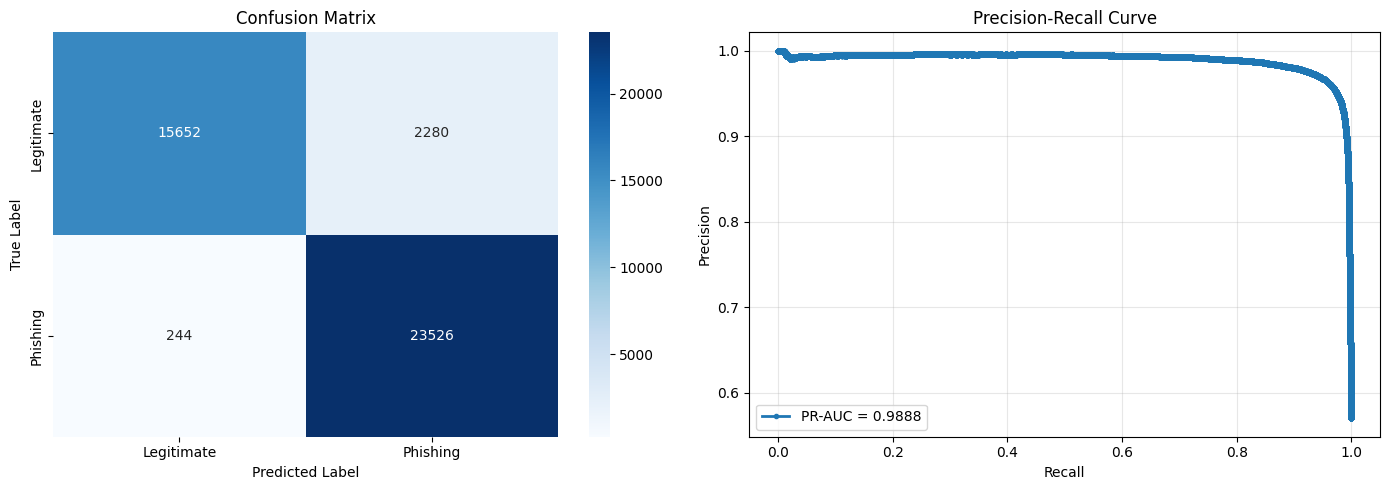


Evaluation complete!


In [25]:
# Create evaluation pipeline with proper max_length handling
class MaxLengthPipeline:
    """Wrapper to handle max_length in pipeline"""
    def __init__(self, base_pipeline, max_length):
        self.pipe = base_pipeline
        self.max_length = max_length
    
    def __call__(self, texts, batch_size=None):
        """Handle both single texts and batches"""
        # Ensure texts is a list
        if isinstance(texts, str):
            texts = [texts]
        
        # Truncate texts to avoid sequence length mismatch
        # Rough estimate: ~4 characters per token
        max_chars = self.max_length * 4
        truncated_texts = []
        for text in texts:
            if len(text) > max_chars:
                text = text[:max_chars]
            truncated_texts.append(text)
        
        # Call the underlying pipeline
        return self.pipe(truncated_texts, batch_size=batch_size)

# Create base pipeline
base_pipeline = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    return_all_scores=True
)

# Wrap it with max_length handling
eval_pipeline = MaxLengthPipeline(base_pipeline, MAX_LENGTH)

# Evaluate on test set
print("Evaluating model on test set...")
test_predictions = []
test_probabilities = []

# Batch prediction for efficiency
batch_size = 32
for i in range(0, len(X_test), batch_size):
    batch_texts = X_test[i:i + batch_size]
    batch_results = eval_pipeline(batch_texts)
    
    for result in batch_results:
        # Handle both nested list and flat list formats
        if isinstance(result, list):  # Nested list: [[{...}, {...}], ...]
            # Extract the scores from the nested list
            scores = {r['label']: r['score'] for r in result}
            phishing_score = scores.get('LABEL_1', 0.0)
        else:  # Single dict: {...}
            phishing_score = result['score'] if result['label'] == 'LABEL_1' else 1 - result['score']
        
        prediction = 1 if phishing_score > 0.5 else 0
        test_predictions.append(prediction)
        test_probabilities.append(phishing_score)

# Convert to numpy arrays
y_pred = np.array(test_predictions)
y_prob = np.array(test_probabilities)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
pr_auc = average_precision_score(y_test, y_prob)

print("\n" + "="*60)
print("TEST SET EVALUATION RESULTS")
print("="*60)
print(f"\nAccuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"PR-AUC:    {pr_auc:.4f}")

# Detailed classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Phishing']))

# Confusion Matrix
print(f"\nConfusion Matrix:")
print(conf_matrix)

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Legitimate', 'Phishing'],
           yticklabels=['Legitimate', 'Phishing'],
           ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
axes[1].plot(recall_curve, precision_curve, marker='.', linewidth=2, label=f'PR-AUC = {pr_auc:.4f}')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nEvaluation complete!")


In [26]:
# Save Model and Results
import json
from datetime import datetime

print("Saving model and results...")

# Create results directory
results_dir = Path("results")
results_dir.mkdir(exist_ok=True)

# Save model and tokenizer
model_dir = Path("models/distilbert-phishing")
if not model_dir.exists():
    model_dir.mkdir(parents=True, exist_ok=True)
    model.save_pretrained(model_dir)
    tokenizer.save_pretrained(model_dir)
    print(f"Model saved to {model_dir}")
else:
    print(f"Model already exists at {model_dir}")

# Save evaluation results
results = {
    "model_info": {
        "model_name": model_name,
        "architecture": "DistilBERT for sequence classification",
        "num_parameters": int(sum(p.numel() for p in model.parameters())),
        "max_length": MAX_LENGTH,
        "training_date": datetime.now().isoformat()
    },
    "dataset_info": {
        "train_size": len(X_train),
        "val_size": len(X_val), 
        "test_size": len(X_test),
        "class_distribution": {
            "legitimate": int(sum(1 for x in y_train if x == 0)),
            "phishing": int(sum(1 for x in y_train if x == 1))
        }
    },
    "performance_metrics": {
        "test_accuracy": float(accuracy),
        "test_precision": float(precision),
        "test_recall": float(recall),
        "test_f1_score": float(f1),
        "test_pr_auc": float(pr_auc)
    }
}

# Save results to JSON
results_file = results_dir / "model_results.json"
with open(results_file, 'w') as f:
    json.dump(results, f, indent=2)
print(f"✓ Results saved to {results_file}")

# Save predictions
predictions_df = pd.DataFrame({
    'text': X_test,
    'true_label': y_test,
    'predicted_label': y_pred,
    'phishing_probability': y_prob,
    'correct_prediction': y_test == y_pred
})

predictions_file = results_dir / "predictions.csv"
predictions_df.to_csv(predictions_file, index=False)
print(f"✓ Predictions saved to {predictions_file}")

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"✓ Model trained: {model_name}")
print(f"✓ Optimization: Option {OPTIMIZATION_CHOICE}")
print(f"✓ Max sequence length: {MAX_LENGTH}")
print(f"✓ Test accuracy: {accuracy:.4f}")
print(f"✓ Test F1-Score: {f1:.4f}")
print(f"\nFiles saved:")
print(f"  - Model: {model_dir}")
print(f"  - Results: {results_file}")
print(f"  - Predictions: {predictions_file}")
print("="*60)


Saving model and results...
Model already exists at models\distilbert-phishing
✓ Results saved to results\model_results.json
✓ Predictions saved to results\predictions.csv

SUMMARY
✓ Model trained: huawei-noah/TinyBERT_General_4L_312D
✓ Optimization: Option 4
✓ Max sequence length: 128
✓ Test accuracy: 0.9395
✓ Test F1-Score: 0.9389

Files saved:
  - Model: models\distilbert-phishing
  - Results: results\model_results.json
  - Predictions: results\predictions.csv


## 10. Save Model and Results

In [28]:
# Save model, tokenizer, and results
import json
from datetime import datetime

print(" Saving model and results...")

# Create results directory
results_dir = Path("results")
results_dir.mkdir(exist_ok=True)

# Save model and tokenizer (if not already saved)
model_dir = Path("models/distilbert-phishing")
if not model_dir.exists():
    model_dir.mkdir(parents=True, exist_ok=True)
    model.save_pretrained(model_dir)
    tokenizer.save_pretrained(model_dir)
    print(f" Model saved to {model_dir}")
else:
    print(f" Model already exists at {model_dir}")

# Save evaluation results
results = {
    "model_info": {
        "model_name": model_name,
        "architecture": "DistilBERT for sequence classification",
        "num_parameters": sum(p.numel() for p in model.parameters()),
        "max_length": MAX_LENGTH,
        "training_date": datetime.now().isoformat()
    },
    "dataset_info": {
        "train_size": len(X_train),
        "val_size": len(X_val), 
        "test_size": len(X_test),
        "class_distribution": {
            "legitimate": int(sum(1 for x in y_train if x == 0)),
            "phishing": int(sum(1 for x in y_train if x == 1))
        }
    },
    "performance_metrics": {
        "test_accuracy": float(accuracy),
        "test_precision": float(precision),
        "test_recall": float(recall),
        "test_f1_score": float(f1),
        "test_pr_auc": float(pr_auc)
    },
    "training_config": {
        "epochs": 10,
        "batch_size": BATCH_SIZE,
        "learning_rate": 3e-4,
        "warmup_steps": 50,
        "weight_decay": 0.01
    }
}

# Save results to JSON
results_file = results_dir / "distilbert_results.json"
with open(results_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Results saved to {results_file}")

# Save predictions for further analysis
predictions_df = pd.DataFrame({
    'text': X_test,
    'true_label': y_test,
    'predicted_label': y_pred,
    'phishing_probability': y_prob,
    'correct_prediction': y_test == y_pred
})

predictions_file = results_dir / "distilbert_predictions.csv"
predictions_df.to_csv(predictions_file, index=False)
print(f"Predictions saved to {predictions_file}")

# Create a simple inference function for future use
def classify_email(text, model_path="models/distilbert-phishing"):
    """
    Classify a single email text using the trained DistilBERT model
    
    Args:
        text (str): Email text to classify
        model_path (str): Path to the saved model
    
    Returns:
        dict: Classification results with prediction and confidence
    """
    # Create pipeline with max_length handling
    classifier = pipeline(
        "text-classification",
        model=model,
        tokenizer=tokenizer,
        return_all_scores=True
    )
    
    # Make prediction
    results = classifier(text)
    
    # Handle both nested list and flat list formats
    if isinstance(results[0], list):
        # Nested list format: [[{...}, {...}]]
        scores = {r['label']: r['score'] for r in results[0]}
        phishing_score = scores.get('LABEL_1', 0.0)
    else:
        # Flat list format: [{...}, {...}]
        scores = {r['label']: r['score'] for r in results}
        phishing_score = scores.get('LABEL_1', 0.0)
    
    prediction = "Phishing" if phishing_score > 0.5 else "Legitimate"
    confidence = phishing_score if prediction == "Phishing" else 1 - phishing_score
    
    return {
        "prediction": prediction,
        "confidence": confidence,
        "phishing_probability": phishing_score,
        "legitimate_probability": 1 - phishing_score
    }

# Save the inference function
import pickle
with open(results_dir / "classify_email_function.pkl", "wb") as f:
    pickle.dump(classify_email, f)

print(f"Inference function saved to {results_dir / 'classify_email_function.pkl'}")

# Summary
print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print(f"Model Performance Summary:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"\nSaved Files:")
print(f"Model: {model_dir}")
print(f"Results: {results_file}")
print(f"Predictions: {predictions_file}")
print(f"\nDistilBERT phishing detection model is ready!")
print("="*60)

# Example usage of the saved model
print(f"\nTesting saved model on sample phishing email:")
sample_text = "Get 50% off PS5! Click here now for amazing deals!"
result = classify_email(sample_text)
print(f"Sample: '{sample_text}'")
print(f"Prediction: {result['prediction']} (confidence: {result['confidence']:.3f})")


 Saving model and results...
 Model already exists at models\distilbert-phishing
Results saved to results\distilbert_results.json


Device set to use cuda:0


Predictions saved to results\distilbert_predictions.csv
Inference function saved to results\classify_email_function.pkl

ANALYSIS COMPLETE!
Model Performance Summary:
Accuracy: 0.9395
F1-Score: 0.9389
PR-AUC: 0.9888

Saved Files:
Model: models\distilbert-phishing
Results: results\distilbert_results.json
Predictions: results\distilbert_predictions.csv

DistilBERT phishing detection model is ready!

Testing saved model on sample phishing email:
Sample: 'Get 50% off PS5! Click here now for amazing deals!'
Prediction: Legitimate (confidence: 0.997)
